In [123]:
import pandas as pd
import numpy as np
from dython.nominal import associations
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from catboost import cv, Pool
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
import shap

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score

In [124]:
pd.set_option('display.max_columns', None)

In [125]:
df = pd.read_excel(path)

## Анализ данных

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10863 entries, 0 to 10862
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10863 non-null  int64  
 1   Filial           10863 non-null  object 
 2   Type_ts          10863 non-null  object 
 3   passport_region  10863 non-null  object 
 4   VIP              284 non-null    object 
 5   Brand            10863 non-null  object 
 6   Model            10863 non-null  object 
 7   Yr_production    10863 non-null  int64  
 8   GAP              10863 non-null  object 
 9   married          10863 non-null  object 
 10  KBM              10863 non-null  int64  
 11  KBM_prol_est     10863 non-null  int64  
 12  delta_kbm        10863 non-null  int64  
 13  deduct           10863 non-null  object 
 14  deduct_amount    10863 non-null  object 
 15  product          10863 non-null  object 
 16  Bank             10863 non-null  object 
 17  channel - ma

In [127]:
df.head()

,ID,Filial,Type_ts,passport_region,VIP,Brand,Model,Yr_production,GAP,married,KBM,KBM_prol_est,delta_kbm,deduct,deduct_amount,product,Bank,channel - map,category,kvs_type,Age,Exp,discount,Amount - gr,sex,premium_car,price_gr,price_prc,OSAGO_clnt,target
0,1,Магнитогорский,Иностранные,Челябинская область,NaN,TOYOTA,RAV 4,2018,Нет,Состоит в браке,8,6,-2,Франшиза 2-ой страховой случай,20000+,Классика,Банк,Автосалоны,NB 0-1,Водители согласно перечню,42,24,1.00,1400000,M,0,55000,0.040,0,0
1,2,Магнитогорский,Отечественные,Челябинская область,NaN,LADA,GRANTA,2016,Нет,Состоит в браке,8,6,-2,Без франшизы,0,Компакт,Банк,Автосалоны,RN,Водители согласно перечню,41,4,1.05,200000,M,0,10000,0.010,0,0
2,3,Ростовский,Отечественные,Ростовская область,NaN,LADA,GRANTA,2018,Нет,Не состоит в браке,8,6,-2,Без франшизы,0,Классика,Банк,Автосалоны,NB 0-1,Водители согласно перечню,49,20,0.95,400000,F,0,30000,0.065,1,1
3,4,Казанский,Иностранные,Республика Татарстан,NaN,KIA,RIO,2016,Нет,Не состоит в браке,8,6,-2,Без франшизы,0,Компакт,Сетелем,Автосалоны,RN,Водители согласно перечню,40,15,1.10,400000,M,0,10000,0.020,1,0
4,5,Московский,Иностранные,Москва,NaN,DATSUN,ON-DO,2018,Нет,Состоит в браке,8,6,-2,Без франшизы,0,Компакт,Без банка,Розница,NB 0-1,Водители согласно перечню,58,23,1.00,400000,M,0,10000,0.015,0,0


исследуем переменные на предмет выбросов и некорректных значений (заодно поймем их значение).

также сравним распределение каждой переменной в тестовой и трейновой выборках

In [128]:
df['Filial'].value_counts() #название филилала, все нормально

Московский               3305
Краснодарский            1153
Санкт - Петербургский    1086
Ростовский                553
Воронежский               474
Казанский                 421
Самарский                 394
Магнитогорский            335
Челябинский               320
Пермский                  307
Ижевский                  276
Уфимский                  270
Нижегородский             269
Тверской                  251
Екатеринбургский          243
Ставропольский            234
Волгоградский             232
Новосибирский             186
Белгородский              182
Кемеровский               171
Тульский                  134
Дальневосточный            67
Name: Filial, dtype: int64

In [129]:
df['Type_ts'].value_counts() #тип машины

Иностранные      8353
Отечественные    2510
Name: Type_ts, dtype: int64

In [130]:
df['passport_region'].value_counts() #есть регион Н.д. (нет данных?)

Москва                          1611
Московская область              1164
Краснодарский край               936
Санкт-Петербург                  739
Ростовская область               544
                                ... 
Магаданская область                2
Еврейская автономная область       2
Чеченская Республика               2
Ненецкий автономный округ          1
Республика Ингушетия               1
Name: passport_region, Length: 85, dtype: int64

In [131]:
df['VIP'].value_counts() # у нас три варианта категорий Випа (без випа н-а), особый статус, и особый статус+.

Особый статус +    201
Особый статус       83
Name: VIP, dtype: int64

In [132]:
df['VIP']=df['VIP'].fillna('Обычный статус') 

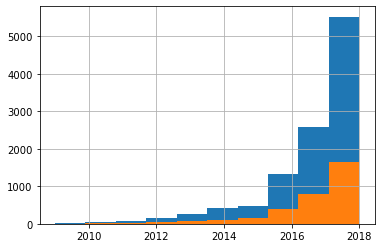

In [133]:
df['Yr_production'].hist()
df[df['target'] == -1]['Yr_production'].hist()

In [134]:
df['GAP'].value_counts() #что бы это ни было
#df[df['target'] == -1]['GAP'].value_counts()

Нет    9749
Да     1114
Name: GAP, dtype: int64

In [135]:
df['married'].value_counts()
#df[df['target'] == -1]['married'].value_counts()

Состоит в браке       8491
Не состоит в браке    2372
Name: married, dtype: int64

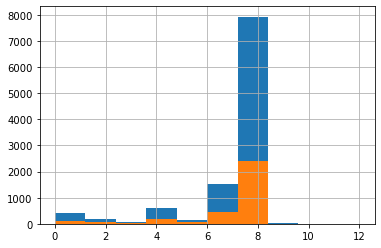

In [136]:
df['KBM'].hist() 
df[df['target'] == -1]['KBM'].hist()
#Судя по таблице КБМ  
#Существует 15 классов страхования водителей. 
#При отсутствии информации о предыдущей страховой истории водителю присваивается класс 3 (КБМ-1).

#это скорее ранговая или категориальная фича. можно еще рпитянуть количественный кожфициент

In [137]:
df['KBM'].value_counts()

8     7924
6     1329
4      592
0      348
2      193
7      188
5      150
3       57
1       55
9       12
10      10
12       3
11       2
Name: KBM, dtype: int64

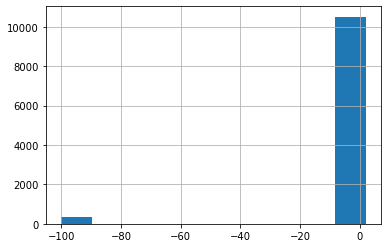

In [138]:
df['delta_kbm'].hist() # тут что-то не так

In [139]:
df['delta_kbm'].value_counts()

-2      9865
-1       577
-100     348
 1        45
 2        14
 0        14
Name: delta_kbm, dtype: int64

In [140]:
#df[df['delta_kbm'] < -10] # минус 100 ставят там где КБМ текущий и будущий = 0.

изменение кбм судя по статье в википедии говорит о том были ли страховые выплаты в этом году.
должно быть если были страховые выпалты то КБМ падает, а если не были растет. но тут у всех почти падает на 2
в этом датасете в основном те кто попадал в аварии?

Для предсказания лучше в дальнейшем представить КБМ-дельта как ктаегориальную фичу и возможно убрать KBM_prol_est.

In [141]:
df['deduct'].value_counts()
df.deduct_amount.value_counts() # все категориальные ранговые фичи

0         7148
20000-    2010
20000+    1705
Name: deduct_amount, dtype: int64

In [142]:
df['product'].value_counts()
df['Bank'].value_counts()
df['channel - map'].value_counts()
df['category'].value_counts()

NB 0-1     6079
RN         3706
RN sppg     590
NB 2+       488
Name: category, dtype: int64

In [143]:
df['kvs_type'].value_counts()

Водители согласно перечню                                          10753
Ограничение по стажу и возрасту, без ограничения количества лиц      110
Name: kvs_type, dtype: int64

In [144]:
df[df['target'] == -1]['kvs_type'].value_counts()

Водители согласно перечню                                          3229
Ограничение по стажу и возрасту, без ограничения количества лиц      36
Name: kvs_type, dtype: int64

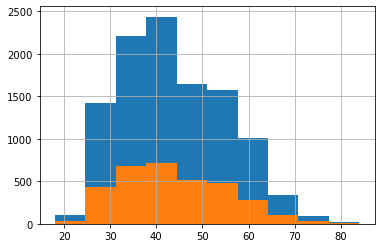

In [145]:
df['Age'].hist()
df[df['target'] == -1]['Age'].hist()

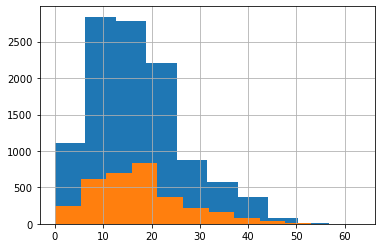

In [146]:
df['Exp'].hist()
df[df['target'] == -1]['Exp'].hist()

In [147]:
df['discount'].value_counts()
# полис стоит от 90 до 110%. по факту тоже можно представить как категориаьные фичи

#df['discount'] = df['discount'] - 0.9
#df['discount'].value_counts() пока не будем так делать

1.00    6427
1.05    1137
0.90    1125
1.10    1103
0.95    1071
Name: discount, dtype: int64

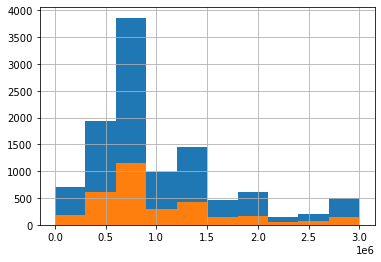

In [148]:
df['Amount - gr'].hist()
df[df['target'] == -1]['Amount - gr'].hist()

In [149]:
df['sex'].value_counts()

# у 5 человек нет данных по полу и так же у них же нет данных по региону

M    7185
F    3673
        5
Name: sex, dtype: int64

In [150]:
df['premium_car'].value_counts()
df[df['target'] == -1]['premium_car'].value_counts() #тут все нормально

0    2988
1     277
Name: premium_car, dtype: int64

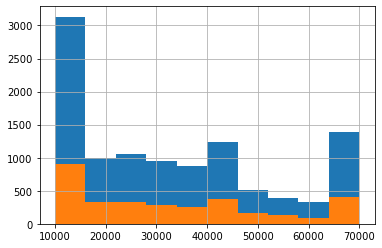

In [151]:
df['price_gr'].hist()
df[df['target'] == -1]['price_gr'].hist()

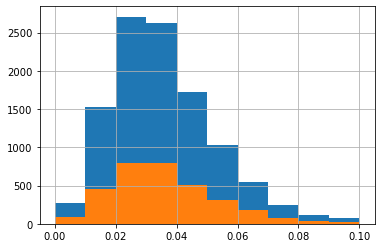

In [152]:
df['price_prc'].hist()
df[df['target'] == -1]['price_prc'].hist()

Заполняем пропуски

In [153]:
def fillnd(data): #заполняем н.д. в 'passport_region' самым частым ваирантом паспорта по региону
    passport_region = data['passport_region']
    Filial = data['Filial']
    if passport_region == "н.д.":
        return df[df['Filial']==Filial]['passport_region'].value_counts().index[0]
    else:
        return passport_region 
    
df['passport_region'] =df.apply(fillnd,axis=1)

In [154]:
#пропуски в поле sex заменим на мужчин
df['sex'] =df['sex'].apply(lambda x : x.replace(" ", "M"))

смотрим распределение зависимой переменной

In [155]:
df['target'].value_counts()
#выборка несбалансированная, но не слишком сильно

 0    5226
-1    3265
 1    2372
Name: target, dtype: int64

Разделим на категриальные и количественные факторы.

In [156]:
cat_features = ['Filial','Type_ts', 'passport_region','VIP', 'Brand', 'Model','GAP', 'married', 'KBM', 'delta_kbm', 'deduct','deduct_amount','product','Bank','channel - map','category','kvs_type', 'sex','premium_car','OSAGO_clnt']

count_features = ['Yr_production','Age','Exp','discount', 'Amount - gr','price_gr','price_prc','KBM_prol_est']

In [157]:
df[cat_features] = df[cat_features].astype(str)

In [158]:
train_df = df[df['target']!= -1]
test_df = df[df['target']== -1]

Посмотрим на асоциации (как кореляция, но от 0 до 1) категориальных признаков. Кусок матрицы в павом нижнем углу это корреляции с количественными признаками.


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


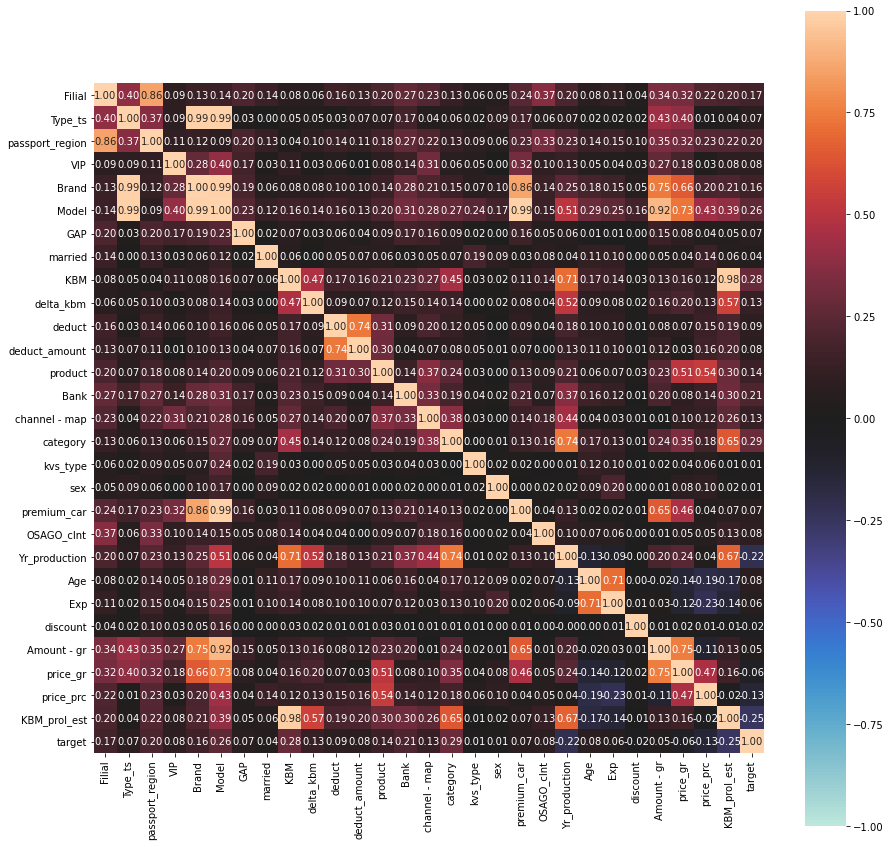

In [159]:
associations(train_df[cat_features+count_features+['target']], figsize=(15, 15))
None

#### Запишем некоторые наблюдения:
Премиальность машины полностью описывается моделью. (можно в опредленной ситуации удалить)

Тип ТС описывается брендом и моделью. (можно в опредленной ситуации удалить)

Модель и бренд так же очевидно прямо связаны. (можно обьеденить их в один признак)

Сумма франшизы сильно связана с типом франшизы.

Amount_gr сильно коррелирует с price_gr.

Год машины сильно связан с множеством факторов.

#### Относительно зависмой переменной:
Наиболее связанными факторами с target являются category, KBM, Yr_production, Model, passport_region, Bank.


## Выбор модели

Обоснование выбора модели.
В данной работе будем использывать градиентный бустинг над решающими деревьями как наиболее сильный и интерпретируемый алгоритм классического мл. 

Если было бы больше времени сперва стоило бы попробывать линейные модели, но они требуют нормализации данных и закодирования категориальных фичей.

В качестве библиотеки градиентного бутсинга будем использывать catboost.

In [178]:
train,valid = train_test_split(train_df, test_size=0.2, random_state=123)

train_features = train[cat_features+count_features]
train_target = train['target']

valid_features =valid[cat_features+count_features]
valid_target = valid['target']


test_features =test_df[cat_features+count_features]


In [161]:
model = CatBoostClassifier(
    iterations=2000,
    random_seed=63,
    learning_rate=0.1,
    early_stopping_rounds= 200,
    custom_loss=['AUC', 'Accuracy'],
    auto_class_weights = 'Balanced'
    
)
model.fit(
    train_features, train_target,
    cat_features=cat_features,
    eval_set=(valid_features, valid_target),
    verbose=False,
    plot=True
)
# сходу больше 0.75 auc не выходит

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [162]:
"""
#подборка гиперпараметров
model = CatBoostClassifier(cat_features=cat_features,
    iterations=2000,
    random_seed=63,
    early_stopping_rounds= 200,
    loss_function='Logloss',
    auto_class_weights = 'Balanced'
                        
)
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model.grid_search(grid, 
                                       train_features, 
                                       train_target, 
                                       search_by_train_test_split = True,
                                       calc_cv_statistics = True,
                                       plot=True)

"""
None

In [163]:
best_params = {'depth': 6, 'l2_leaf_reg': 1, 
 'learning_rate': 0.03,
'loss_function' :'Logloss',
'auto_class_weights' :'Balanced'}

In [164]:
model = CatBoostClassifier(
    iterations=2000,
    random_seed=63,
    early_stopping_rounds= 200,
    depth=6, 
    l2_leaf_reg= 1, 
    learning_rate=0.03,
    custom_loss=['AUC', 'Accuracy'],
    #one_hot_max_size=1000
    #auto_class_weights = 'Balanced'
    
)
model.fit(
    train_features, train_target,
    cat_features=cat_features,
    eval_set=(valid_features, valid_target),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [165]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,product,11.402735
1,category,10.389935
2,Yr_production,8.544941
3,Bank,7.633968
4,Filial,7.543308
5,price_prc,6.538891
6,KBM,5.449660
7,Brand,5.337730
8,passport_region,4.674395
9,Model,3.846382


In [166]:
to_drop = ['GAP',
'Type_ts',
'channel - map',
'married',
'sex',
'kvs_type',
'premium_car',]
# если убрать ти признаки качество немного вырастет

In [167]:
#можно рассмотреть какие признаки оказывают каое влияние на конкретное значение
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(train_features, train_target, cat_features=cat_features))

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[50,:], train_features.iloc[50,:]) #50 элемент

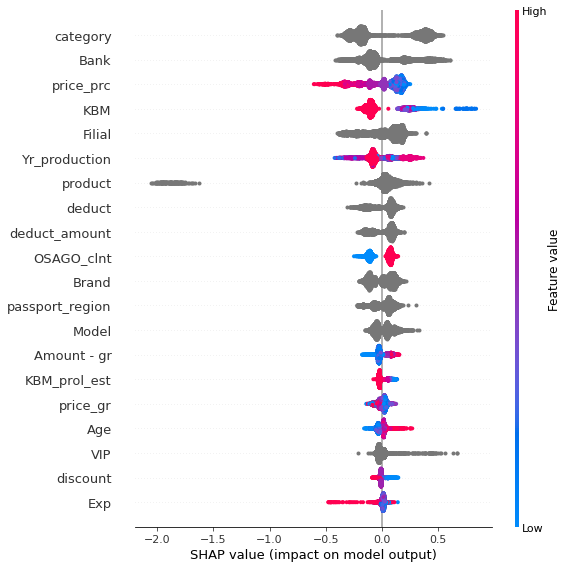

In [168]:
shap.summary_plot(shap_values, train_features)

In [169]:
proba = model.predict_proba(valid_features)[:,1]
print(roc_auc_score(valid_target,proba.round()))
print(f1_score(valid_target,proba.round()))

0.6386803553080773
0.47137150466045274


In [170]:
errors = confusion_matrix(valid_target,proba.round())
errors
#TN 946, TP 177, FN 275, FP 122

array([[946, 122],
       [275, 177]])

In [171]:
accuracy_score(valid_target,proba.round())

0.7388157894736842

качество предсказания получается плохое даже на валидации.

Можно улучшить предсказания создавая новые фичи, удалив лишние и правильно интерпертировав существующие (особенно связанные с КБМ), анализируя по одному значения и так далее.

Но для того что бы быстро получить неинтерпретируем лучший результат исопльузем другую модель.

# NN

In [172]:
#предобработка, кодирвоание фичей, нормализация и разделение выборок
data = df[cat_features+count_features +["target"]]
dummies = pd.get_dummies(data[cat_features],drop_first=True)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data[count_features])

data_nn = dummies.join(pd.DataFrame(scaled))

data_nn = data_nn.join(data['target'])

data_nn_train = data_nn[data_nn['target']!=-1]
data_nn_test = data_nn[data_nn['target']==-1]

data_nn_train_values = data_nn_train.drop('target',axis=1)
data_nn_train_target = data_nn_train['target']

data_nn_test = data_nn_test.drop('target',axis=1)


In [173]:
len_data = data_nn_train_values.shape[1]

In [174]:
def mynn(): 
    inputs = Input(name='inputs',shape=[len_data])
    
    layer = Dense(128)(inputs)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(64)(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)
    
    layer = Dense(32)(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)
    
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [175]:
modelnn = mynn()
modelnn.summary()
modelnn.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 372)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               47744     
_________________________________________________________________
activation_8 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_9 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)               

In [176]:
modelnn.fit(data_nn_train_values,data_nn_train_target,epochs=50,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=5)])

Epoch 1/50
190/190 [==============================] - 1s 4ms/step - loss: 0.5785 - accuracy: 0.7066 - val_loss: 0.5622 - val_accuracy: 0.7013
Epoch 2/50
190/190 [==============================] - 0s 2ms/step - loss: 0.5484 - accuracy: 0.7289 - val_loss: 0.5546 - val_accuracy: 0.7112
Epoch 3/50
190/190 [==============================] - 0s 2ms/step - loss: 0.5371 - accuracy: 0.7399 - val_loss: 0.5555 - val_accuracy: 0.7046
Epoch 4/50
190/190 [==============================] - 0s 2ms/step - loss: 0.5293 - accuracy: 0.7447 - val_loss: 0.5604 - val_accuracy: 0.6967
Epoch 5/50
190/190 [==============================] - 0s 2ms/step - loss: 0.5195 - accuracy: 0.7471 - val_loss: 0.5613 - val_accuracy: 0.6993
Epoch 6/50
190/190 [==============================] - 0s 2ms/step - loss: 0.5102 - accuracy: 0.7506 - val_loss: 0.5563 - val_accuracy: 0.7013
Epoch 7/50
190/190 [==============================] - 0s 2ms/step - loss: 0.5040 - accuracy: 0.7545 - val_loss: 0.5610 - val_accuracy: 0.7026


# Предсказываем

In [182]:
predsCatboost = model.predict_proba(test_features)[:,1]

In [184]:
predsNN =modelnn.predict(data_nn_test)

In [187]:
test_features['cat_predict'] = predsCatboost
test_features['nn_predict'] = predsNN


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Засумируем предсказания моделей. (обычно я не стал бы так делать, но вероятно в данном задании мне нужно получить лучший результат чем у других кандидатов за короткие сроки)

In [189]:
test_features['final_proba'] = (test_features['cat_predict'] + test_features['nn_predict'])/2

In [190]:
test_features['final_predict'] = test_features['final_proba'].round()

In [193]:
test_features.to_excel("predictions.xlsx")

Что еще можно было бы сделать.
-удалить лишние фичи протестироваться с ними.
-добавить признаков, особенно разобраться с KBM.

Изучить по одному ошибки модели и какое влияние на них оказвали признаки и таким образом корректирвоать признаки и улчшать качество модели